In [1]:
import numpy as np
import cv2
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import os
import sys
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm as svm_sk
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

# Preprocessing Training data
fruit_images_t = []
labels_t = [] 
for fruit_dir_path in glob.glob("fruits-360/Training/*"):
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        fruit_images_t.append(image)
        labels_t.append(fruit_label)
fruit_images_t = np.array(fruit_images_t)
labels_t = np.array(labels_t)

# Preprocessing Validation data
fruit_images_v = []
labels_v = [] 
for fruit_dir_path in glob.glob("fruits-360/Validation/*"):
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        fruit_images_v.append(image)
        labels_v.append(fruit_label)
fruit_images_v = np.array(fruit_images_v)
labels_v = np.array(labels_v)

# Create dicts/arrays for Training Data
names_t = np.unique(labels_t)
ids_t = [k for k in range(0, len(names_t))]
name_id_t = list(zip(names_t, ids_t))
id_to_name_t = {id: name for (name, id) in name_id_t}
name_to_id_t = {name: id for (name, id) in name_id_t}
label_ids_t = np.array([name_to_id_t[x] for x in labels_t])

# Create dicts/arrays for Validation data
names_v = np.unique(labels_v)
ids_v = [k for k in range(len(names_v))]
id_name_v = list(zip(ids_v, names_v))
name_to_id_v = {name: id for (id, name) in id_name_v}
id_to_name_v = {id: name for (id, name) in id_name_v}
label_ids_v = np.array([name_to_id_v[x] for x in labels_v])

#End of preprocessing stage

In [2]:
# PCA Cell
# Scale Training data and then run PCA on it
scaler = StandardScaler()
scaled_images = scaler.fit_transform([im.flatten() for im in fruit_images_t])
pca = PCA(n_components=80)
pca_result_t = pca.fit_transform(scaled_images)

# Split training set
X_train, X_test, y_train, y_test = train_test_split(pca_result_t, label_ids_t, test_size=0.6)

# Scale Validation Data and run PCA on it
images_scaled = scaler.transform([im.flatten() for im in fruit_images_v])
pca_result_v = pca.transform(images_scaled)

Accuracy with SVM on X_test: 90.940726


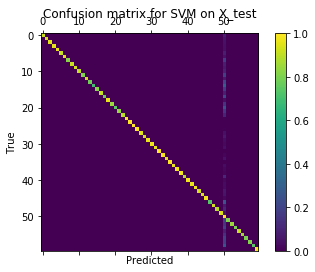

In [8]:
# Train SVM
svm = svm_sk.SVC()
svm = svm.fit(X_train, y_train)

# Make predictions w/ both classifiers
svm_test_predictions = svm.predict(X_test)

# Compute accuracy scores
svm_precision_t = accuracy_score(svm_test_predictions, y_test) * 100
print("Accuracy with SVM on X_test: {0:.6f}".format(svm_precision_t))

# Compute Confusion Matrices for both classifiers
cm_svm_t = confusion_matrix(y_test, svm_test_predictions)
cm_svm_t = normalize(cm_svm_t, axis=1, norm='l1')

# Plot both confusion matrices (separate windows)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_svm_t)
plt.title('Confusion matrix for SVM on X_test')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [9]:
# Predict on with all classifiers Validation data
svm_prediction_v = svm.predict(pca_result_v)

# Compute accuracy scores for all classifiers
svm_precision_v = accuracy_score(svm_prediction_v, label_ids_v) * 100

print("Accuracy with SVM on Validation data: {0:.6f}".format(svm_precision_v))

# Compute confusion matrices for all classifiers
cm_svm_v = confusion_matrix(label_ids_v, svm_prediction_v)
cm_svm_v = normalize(cm_svm_v, axis=1, norm='l1')

Accuracy with SVM on Validation data: 46.376512


Accuracy with SVM on X_test: 90.940726
Accuracy with RF on X_test: 98.538453


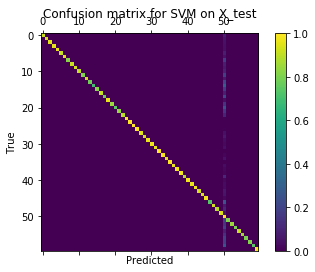

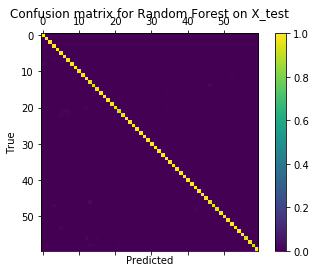

Accuracy with SVM on Validation data: 46.376512
Accuracy with RF on Validation data: 80.843585
[('Pomegranate', 0.3780487804878049), ('Apple Red 3', 0.4166666666666667), ('Banana Red', 0.4578313253012048), ('Nectarine', 0.5121951219512195), ('Plum', 0.5695364238410596), ('Apple Red 1', 0.5853658536585366), ('Peach Flat', 0.6097560975609756), ('Apricot', 0.6158536585365854), ('Pear', 0.6341463414634146), ('Pepino', 0.6385542168674698)]
---------------
[('Banana Red', 'Banana', 0.3493975903614458), ('Pear', 'Apple Golden 3', 0.27439024390243905), ('Apple Golden 1', 'Apple Golden 3', 0.25), ('Apple Red 3', 'Peach', 0.2152777777777778), ('Plum', 'Cherry', 0.2119205298013245), ('Nectarine', 'Apple Red Yellow', 0.20121951219512196), ('Cactus fruit', 'Banana Red', 0.18674698795180722), ('Apple Red 3', 'Nectarine', 0.18055555555555555), ('Apple Granny Smith', 'Apple Golden 3', 0.17682926829268292), ('Clementine', 'Kaki', 0.1746987951807229), ('Apple Red 2', 'Apple Braeburn', 0.1707317073170731

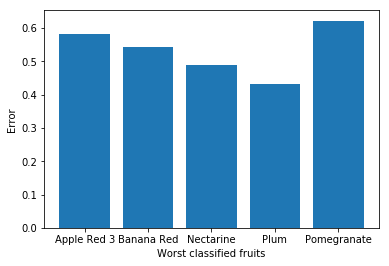

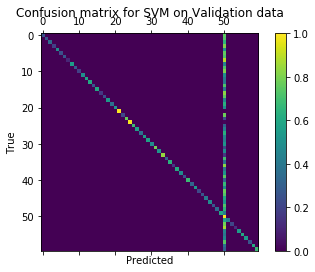

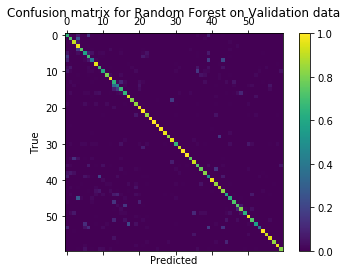

In [7]:
# Train Random Forest
forest = RandomForestClassifier(n_estimators=10)
forest = forest.fit(X_train, y_train)

# Make predictions w/ both classifiers
forest_test_predictions = forest.predict(X_test)

# Compute accuracy scores
forest_precision_t = accuracy_score(forest_test_predictions, y_test) * 100 
print("Accuracy with RF on X_test: {0:.6f}".format(forest_precision_t))

# Compute Confusion Matrices for both classifiers
cm_forest_t = confusion_matrix(y_test, forest_test_predictions)
cm_forest_t = normalize(cm_forest_t, axis=1, norm='l1')

# Plot both confusion matrices (separate windows)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_forest_t)
plt.title('Confusion matrix for Random Forest on X_test')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Predict on with all classifiers Validation data
forest_prediction_v = forest.predict(pca_result_v)

# Compute accuracy scores for all classifiers
forest_precision_v = accuracy_score(forest_prediction_v, label_ids_v) * 100


print("Accuracy with RF on Validation data: {0:.6f}".format(forest_precision_v))

# Compute confusion matrices for all classifiers
cm_forest_v = confusion_matrix(label_ids_v, forest_prediction_v)
cm_forest_v = normalize(cm_forest_v, axis=1, norm='l1')

In [ ]:
# Find worst mismatches in Forest classifier
n = cm_forest_v.shape[0]
mismatches = np.zeros((n,n))
matches = np.zeros(n)

for r in range(n):
    for c in range(n):
        if r == c:
            matches[r] = cm_forest_v[r,c]
            continue
        mismatches[r,c] = cm_forest_v[r,c]
        
# Find and print the most 20 worst mismatches and the 10 worst performing classes
mismatches_sorted = np.dstack(np.unravel_index(np.flipud(np.argsort(mismatches.flatten())),(n,n))).reshape(n*n,2)
worst_mismatches = [(id_to_name_v[x[0]], id_to_name_v[x[1]], mismatches[x[0],x[1]])  for x in mismatches_sorted[0:20,:]]
classes_sorted = np.argsort(matches)
worst_classes = [(id_to_name_v[x], matches[x]) for x in classes_sorted[0:10]]
print(worst_classes)
print('---------------')
print(worst_mismatches)
# kdoak
worst = [id_to_name_v[x] for x in classes_sorted[:5]]
error_worst = [(1-matches[x]) for x in classes_sorted[:5]]
best_classes = [(id_to_name_v[x], matches[x]) for x in classes_sorted[-10:]]
fig = plt.figure()
plt.bar(worst, error_worst)
plt.xlabel('Worst classified fruits')
plt.ylabel('Error')
print(best_classes)

# Plot both confusion matrices (separate windows)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_svm_v)
plt.title('Confusion matrix for SVM on Validation data')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_forest_v)
plt.title('Confusion matrix for Random Forest on Validation data')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()